<AxesSubplot: ylabel='Count'>

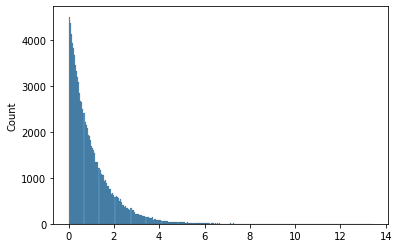

In [1]:
import random
import seaborn

values = [random.expovariate(1) for _ in range(100000)]
seaborn.histplot(values)

<AxesSubplot: ylabel='Count'>

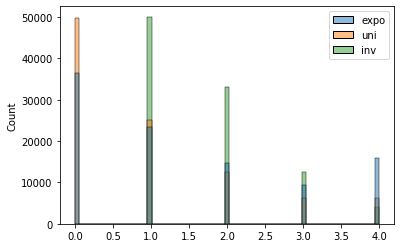

In [15]:
def gen_depth(cont_expression):
    d = 0
    while d < 4 and cont_expression(d):
        d += 1
    return d

expo_depths = [gen_depth(lambda depth: random.expovariate(1) < 1) for _ in range(100000)]
uni_depths = [gen_depth(lambda depth: random.random()<0.5) for _ in range(100000)]
inv_depths = [gen_depth(lambda depth: random.random() < 1/(depth+1)) for _ in range(100000)]
seaborn.histplot({"expo": expo_depths, "uni": uni_depths, "inv": inv_depths})

In [4]:
import itertools

class Symbols:
    def __init__(self, funcs:list, leaf_vars: list, max_const: int):
        self.funcs = funcs
        self.leaf_vars = leaf_vars
        self.leaf_consts = list(range(-max_const, max_const+1))
        self.max_const = max_const


# Recursive Generator! Ahhh!!
# In retrospect I can see that this is just an overcomplicated, generator-based version of a BFS search. Oops.
def systematic_expression_recursive(syms: Symbols, depth):
    # Start with vars, constants
    if depth == 0:
        for atom in itertools.chain(syms.leaf_vars, syms.leaf_consts): yield atom
    elif depth==1:
        
        # Start with +/- (with strictly positive constants on the right)
        for func, left, right in itertools.product(["+", "-"], syms.leaf_vars, itertools.chain(syms.leaf_vars, range(1, syms.max_const+1))):
            if left == right: continue
            yield [func, left, right]
        # Then * (excluding 0 and 1 but including negative numbers on the right)
        for left, right in itertools.product(syms.leaf_vars, itertools.chain(syms.leaf_vars, range(-syms.max_const, 0), range(2, syms.max_const+1))):
            yield ["*", left, right]
    else:
        # For depth>0 expressions, use some intelligence. Skip expressions:
        #  - of only constants (ex: 1-2)
        #  - that are reorderings of the same expression (ex: 1+2, 2+1)
        #  - that involve restatements of the same constant op (ex: x+1, x- (-1))
        #  - that are redundant/don't add to an expression (x*0, x+0, x-x, x*1)
        # To do this:
        #  - enforce some left/right order (variable left, variable or constant left)
        #  - Since we have +/- ops, we can get away with only using non-negative constants
        #  - Since zero is always redundant (x*0 could just be the constant 0, x+0 just x), can use only strictly positive constants
        #  - Use different rules for multiplication (x*1 is redundant for mult, x*(-1) is not)
        # This is going to involve hardcoding functions. Alas.
        # Some rough testing showed this reduced the number of depth-1 expressions from 200 to 50 (such nice, even numbers!)
        # ... and depth 2 from 7500-ish (with depth-1-only filtering) to 6395 (unimpressive, actually)
        # ... and depth 3 from 169117742 (this was even with filtering on depth-1 expressions) to 120935795 (a 28% reduction, that's something I guess)
        strictly_positive = list(range(1, syms.max_const+1))
        right_atoms = {
            "+" : syms.leaf_vars + strictly_positive,
            "-" : syms.leaf_vars + strictly_positive,
            "*" : syms.leaf_vars + list(range(-syms.max_const, 0)) + list(range(2, syms.max_const+1))
        }
        # If depth=1, we want to use to the same fill logic, but never fill right or left
        # This is funky but I promise the code is more compact this way
        fill_vals = ((False,), (False, )) if depth==1 else ((False, True), (False, True))
        for func, fill_left, fill_right in itertools.product(["+", "-", "*"], *fill_vals):
            left_gen = systematic_expression_recursive(syms, depth - 1) if fill_left else syms.leaf_vars
            right_gen = systematic_expression_recursive(syms, depth - 1) if fill_right else right_atoms[func]
            for left, right in itertools.product(left_gen, right_gen):
                if func=="-" and left==right: continue
                yield [func, left, right]
    

def systematic_expression(syms: Symbols, max_depth):
    for depth in range(max_depth+1):
        for expr in systematic_expression_recursive(syms, depth):
            yield expr


In [3]:
import operator
def distinct_expressions(expressions):
    def tupleafy(expression):
        if not isinstance(expression, list): return expression
        return (expression[0], tupleafy(expression[1]), tupleafy(expression[2]))
    return {tupleafy(expression) for expression in expressions}

def evaluate(expression, bindings):
    if isinstance(expression, int): return expression
    if isinstance(expression, str): return bindings[expression]
    return bindings[expression[0]](evaluate(expression[1], bindings), evaluate(expression[2], bindings))

def evaluate_default(expression, bindings):
    return evaluate(expression, bindings | {"+": operator.add, "-": operator.sub, "*": operator.mul})

def generate_rest(initial_sequence, expression, length_to_generate):
    if length_to_generate==0: return []
    sequence = initial_sequence
    starting_i = len(initial_sequence)
    for i in range(starting_i, starting_i+length_to_generate):
        sequence.append(evaluate_default(expression, {"x": sequence[i-2], "y": sequence[i-1], "i": i}))
    return sequence[-length_to_generate:]

In [30]:
n_sample = 1000
syms = Symbols(["+", "-", "*"], ["x", "y", "i"], 2)
sample = list(itertools.islice(systematic_expression(syms, 3), n_sample))
dsample = distinct_expressions(sample)

def is_mul_neg(expression):
    if not isinstance(expression, tuple): return False
    if isinstance(expression[1], tuple) and is_mul_neg(expression[1]): return True
    if isinstance(expression[2], tuple) and is_mul_neg(expression[2]): return True
    return not isinstance(expression[2], str) and expression[0]=="*" and expression[2]<0

seq_expressions = {}
duplicates = []
mul_neg = set()
mul_neg_dup = set()
for expression in dsample:
    mn = is_mul_neg(expression)
    if mn: mul_neg.add(expression)
    fingerprint = tuple(evaluate_default(expression, {"x": x, "y": y, "i": i}) for x, y, i in itertools.product(range(-2, 3), range(-2, 3), range(3)))
    if fingerprint in seq_expressions:
        duplicates.append((expression, seq_expressions[fingerprint]))
        if mn: mul_neg_dup.add(expression)
        if seq_expressions[fingerprint] in mul_neg: mul_neg_dup.add(seq_expressions[fingerprint])
    else:
        seq_expressions[fingerprint] = expression
print(len(duplicates), "out of", len(dsample), "expressions are duplicates")

652 out of 988 expressions are duplicates


In [32]:
print(f"Mul negs: {len(mul_neg)}, of which {len(mul_neg_dup)} are duplicates")

Mul negs: 138, of which 111 are duplicates


In [28]:
dsample

{('*', 'i', 'i'),
 ('*', 'i', 'x'),
 ('*', 'i', 'y'),
 ('*', 'i', -1),
 ('*', 'i', -2),
 ('*', 'i', 2),
 ('*', 'x', 'i'),
 ('*', 'x', 'x'),
 ('*', 'x', 'y'),
 ('*', 'x', -1),
 ('*', 'x', -2),
 ('*', 'x', 2),
 ('*', 'y', 'i'),
 ('*', 'y', 'x'),
 ('*', 'y', 'y'),
 ('*', 'y', -1),
 ('*', 'y', -2),
 ('*', 'y', 2),
 ('+', 'i', 'i'),
 ('+', 'i', 'x'),
 ('+', 'i', 'y'),
 ('+', 'i', ('*', 'i', 'i')),
 ('+', 'i', ('*', 'i', 'x')),
 ('+', 'i', ('*', 'i', 'y')),
 ('+', 'i', ('*', 'i', -1)),
 ('+', 'i', ('*', 'i', -2)),
 ('+', 'i', ('*', 'i', 2)),
 ('+', 'i', ('*', 'x', 'i')),
 ('+', 'i', ('*', 'x', 'x')),
 ('+', 'i', ('*', 'x', 'y')),
 ('+', 'i', ('*', 'x', -1)),
 ('+', 'i', ('*', 'x', -2)),
 ('+', 'i', ('*', 'x', 2)),
 ('+', 'i', ('*', 'y', 'i')),
 ('+', 'i', ('*', 'y', 'x')),
 ('+', 'i', ('*', 'y', 'y')),
 ('+', 'i', ('*', 'y', -1)),
 ('+', 'i', ('*', 'y', -2)),
 ('+', 'i', ('*', 'y', 2)),
 ('+', 'i', ('+', 'i', 'x')),
 ('+', 'i', ('+', 'i', 'y')),
 ('+', 'i', ('+', 'i', 1)),
 ('+', 'i', ('+', 

In [25]:
is_mul_neg(["*", "y", -1])

True

In [33]:
sample

['x',
 'y',
 'i',
 -2,
 -1,
 0,
 1,
 2,
 ['+', 'x', 'y'],
 ['+', 'x', 'i'],
 ['+', 'x', 1],
 ['+', 'x', 2],
 ['+', 'y', 'x'],
 ['+', 'y', 'i'],
 ['+', 'y', 1],
 ['+', 'y', 2],
 ['+', 'i', 'x'],
 ['+', 'i', 'y'],
 ['+', 'i', 1],
 ['+', 'i', 2],
 ['-', 'x', 'y'],
 ['-', 'x', 'i'],
 ['-', 'x', 1],
 ['-', 'x', 2],
 ['-', 'y', 'x'],
 ['-', 'y', 'i'],
 ['-', 'y', 1],
 ['-', 'y', 2],
 ['-', 'i', 'x'],
 ['-', 'i', 'y'],
 ['-', 'i', 1],
 ['-', 'i', 2],
 ['*', 'x', 'x'],
 ['*', 'x', 'y'],
 ['*', 'x', 'i'],
 ['*', 'x', -2],
 ['*', 'x', -1],
 ['*', 'x', 2],
 ['*', 'y', 'x'],
 ['*', 'y', 'y'],
 ['*', 'y', 'i'],
 ['*', 'y', -2],
 ['*', 'y', -1],
 ['*', 'y', 2],
 ['*', 'i', 'x'],
 ['*', 'i', 'y'],
 ['*', 'i', 'i'],
 ['*', 'i', -2],
 ['*', 'i', -1],
 ['*', 'i', 2],
 ['+', 'x', 'x'],
 ['+', 'x', 'y'],
 ['+', 'x', 'i'],
 ['+', 'x', 1],
 ['+', 'x', 2],
 ['+', 'y', 'x'],
 ['+', 'y', 'y'],
 ['+', 'y', 'i'],
 ['+', 'y', 1],
 ['+', 'y', 2],
 ['+', 'i', 'x'],
 ['+', 'i', 'y'],
 ['+', 'i', 'i'],
 ['+', 'i', 1]

In [34]:
seq = [15, 29, 56, 108, 208]
list(s1-s0 for s0, s1 in zip(seq[:-1], seq[1:]))

[14, 27, 52, 100]

In [ ]:
a(n) = 2 * a(n-1) - 2^i